[data set from kaggle](https://www.kaggle.com/tmdb/tmdb-movie-metadata#tmdb_5000_movies.csv)

### Data Overview
* 2 files - 1 with full cast and crew credits other has movie metadata around the relase, language, popularity etc.
* file 1: credits
    * 4 columns, 4800 movies
    * 1 json of crew id/name/job and 1 json of cast character/actor/gender/id
* file 2: movie metadata
    * continuous variables: release_date, revenue, runtime, vote average (1-10), vote_count
    * categorical variables: genre (json needs parsing), keywords (thems like 'space war' also json), original language (mostly english), plot overview, production company, production_countries, 

In [44]:
import pandas as pd
import seaborn as sns
import numpy as np
from pandas.io.json import json_normalize
import json

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, roc_auc_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR

import matplotlib.pyplot as plt 
%matplotlib inline

In [ ]:
df_movies = pd.DataFrame(pd.read_csv('tmdb/tmdb_5000_movies.csv'))
df_movies = df_movies.rename(columns={'id':'movie_id'})

In [11]:
# import credits file
#df_credits = pd.DataFrame(pd.read_csv('tmdb/tmdb_5000_credits.csv'))

# import movie file
df_movies = pd.DataFrame(pd.read_csv('tmdb/tmdb_5000_movies.csv'))
df_movies = df_movies[df_movies['release_date']>='2010-01-01']
df_movies = df_movies.rename(columns={'id':'movie_id'})
df_movies = df_movies[['movie_id','title','release_date','runtime','budget','revenue', 
                       'popularity','vote_average', 'vote_count']]

# Shuffle Dataset
df_movies['random_number'] = np.random.rand(len(df_movies['movie_id']),1)

df_movies = df_movies.sort_values(by='random_number').set_index(['movie_id'])
df_movies = df_movies[df_movies['runtime']>0.0]

df_movies['budget_sqrt'] = np.sqrt(df_movies['budget']) 
df_movies['revenue_sqrt'] = np.sqrt(df_movies['revenue']) 
df_movies['popularity_sqrt'] = np.sqrt(df_movies['popularity']) 
df_movies['vote_count_sqrt'] = np.sqrt(df_movies['vote_count']) 

In [12]:
X = df_movies[['budget', 'revenue', 'popularity','runtime', 'vote_count',
               'budget_sqrt', 'revenue_sqrt', 
               'popularity_sqrt', 'vote_count_sqrt']]

y = df_movies['vote_average']
y = y.astype('int')

In [13]:
n_estimators_range = np.arange(120, 170, 10) # 1- 200
max_depth_range = np.arange(4, 8, 2)

model_instance = RandomForestRegressor()

param_grid = dict(n_estimators=n_estimators_range, 
                   max_depth=max_depth_range)
grid = GridSearchCV(model_instance, param_grid, cv=3, scoring='r2')


grid.fit(X,y)


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([120, 130, 140, 150, 160]), 'max_depth': array([4, 6])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [14]:
print('best score {}'.format(grid.best_score_))
print('n\best parameters {}'.format(grid.best_params_))
print('n\best estimator {}'.format(grid.best_estimator_))

best score 0.5667587698476203
nest parameters {'max_depth': 6, 'n_estimators': 150}
nest estimator RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [48]:


# Incorporate Gridsearch into a pipeline
pipe_forest = Pipeline(steps=[('scl', StandardScaler()), 
                         ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 170, 10), # 1- 200
                                                           'max_depth': np.arange(4, 8, 1)}, 
                                               cv=3,
                                               scoring='neg_mean_squared_error',
                                               refit=False))])

pipe_lasso = Pipeline(steps=[('scl', MinMaxScaler()),
                             ('grid', GridSearchCV(Lasso(fit_intercept=False),
                                             param_grid={'alpha':np.arange(0.00001, 1.0, 0.01)},
                                             cv=3,
                                             scoring='neg_mean_squared_error',
                                             refit=False))])

pipe_ridge = Pipeline(steps=[('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(Ridge(fit_intercept=False),
                                             param_grid={'alpha':np.arange(.01, 3, .2)},
                                             cv=3,
                                             scoring='neg_mean_squared_error',
                                             refit=False))])

pipe_svm = Pipeline(steps=[('scl', MinMaxScaler()),
                           ('pca', PCA(n_components=5)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.arange(100, 120, 1)},
                                             cv=3,
                                             scoring='neg_mean_squared_error',
                                             refit=False))])
# List of pipelines for ease of iteration
pipelines = [pipe_forest, pipe_lasso, pipe_ridge, pipe_svm]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Random Forest', 1: 'Lasso Penalty', 2: 'Ridge Penalty', 3: 'SVM'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X, y)

# Compare accuracies
for idx, grid in enumerate(pipelines):
    print('%s pipeline test R-square: %.3f with parameters: %s' % (pipe_dict[idx], 
                                                                   grid.named_steps['grid'].best_score_, 
                                                                   grid.named_steps['grid'].best_params_))

# Identify the most accurate model on test data
best_neg_mean_squared_error = 0.0
best_regression = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
    if val.named_steps['grid'].best_score_ > best_neg_mean_squared_error:
        best_neg_mean_squared_error = val.named_steps['grid'].best_score_
        best_pipe = grid
        best_regression = idx
print('Regressor with best negative mean squared error: %s' % pipe_dict[best_regression])

# Save pipeline to file
#joblib.dump(best_pipe, 'best_pipeline.pkl', compress=1)
#print('Saved %s pipeline to file' % pipe_dict[best_regression])

Random Forest pipeline test R-square: -0.747 with parameters: {'max_depth': 6, 'n_estimators': 130}
Lasso Penalty pipeline test R-square: -1.587 with parameters: {'alpha': 1e-05}
Ridge Penalty pipeline test R-square: -1.578 with parameters: {'alpha': 0.21000000000000002}
SVM pipeline test R-square: -1.257 with parameters: {'C': 119}
Regressor with best negative mean squared error: Random Forest


In [50]:
X = df_movies[['budget', 'revenue','runtime']]

y = df_movies['vote_average']
y = y.astype('int')

# Incorporate Gridsearch into a pipeline
pipe_forest = Pipeline(steps=[('scl', StandardScaler()), 
                         ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 170, 10), # 1- 200
                                                           'max_depth': np.arange(4, 8, 1)}, 
                                               cv=3,
                                               scoring='r2',
                                               refit=False))])

pipe_lasso = Pipeline(steps=[('scl', MinMaxScaler()),
                             ('grid', GridSearchCV(Lasso(fit_intercept=False),
                                             param_grid={'alpha':np.arange(0.00001, 1.0, 0.01)},
                                             cv=3,
                                             scoring='r2',
                                             refit=False))])

pipe_ridge = Pipeline(steps=[('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(Ridge(fit_intercept=False),
                                             param_grid={'alpha':np.arange(.01, 3, .2)},
                                             cv=3,
                                             scoring='r2',
                                             refit=False))])

pipe_svm = Pipeline(steps=[('scl', MinMaxScaler()),
                           #('pca', PCA(n_components=5)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.arange(100, 120, 1)},
                                             cv=3,
                                             scoring='r2',
                                             refit=False))])


# List of pipelines for ease of iteration
pipelines = [pipe_forest, pipe_lasso, pipe_ridge, pipe_svm]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Random Forest', 1: 'Lasso Penalty', 2: 'Ridge Penalty', 3: 'SVM'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X, y)

# Compare accuracies
for idx, grid in enumerate(pipelines):
    print('%s pipeline test R-square: %.3f with parameters: %s' % (pipe_dict[idx], 
                                                                   grid.named_steps['grid'].best_score_, 
                                                                   grid.named_steps['grid'].best_params_))

# Identify the most accurate model on test data
best_rsquared = 0.0
best_regression = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
    if val.named_steps['grid'].best_score_ > best_rsquared:
        best_rsquared = val.named_steps['grid'].best_score_
        best_pipe = grid
        best_regression = idx
print('Regressor with best r squared: %s' % pipe_dict[best_regression])

# Save pipeline to file
#joblib.dump(best_pipe, 'best_pipeline.pkl', compress=1)
#print('Saved %s pipeline to file' % pipe_dict[best_regression])

Random Forest pipeline test R-square: 0.194 with parameters: {'max_depth': 4, 'n_estimators': 130}
Lasso Penalty pipeline test R-square: -0.180 with parameters: {'alpha': 1e-05}
Ridge Penalty pipeline test R-square: -0.180 with parameters: {'alpha': 0.01}
SVM pipeline test R-square: 0.140 with parameters: {'C': 119}
Regressor with best r squared: Random Forest


In [42]:
pipe_svm = Pipeline(steps=[('scl', MinMaxScaler()),
                           ('pca', PCA(n_components=5)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.arange(100, 120, 1)},
                                             cv=3,
                                             scoring='r2',
                                             refit=False))])

pipe_svm.fit(X,y)
print('best score {}'.format(pipe_svm.named_steps['grid'].best_score_))
print('\nbest parameters {}'.format(pipe_svm.named_steps['grid'].best_params_))

best score 0.28155623215060455

best parameters {'C': 119}


In [27]:
print('best score {}'.format(pipe_svm.named_steps['grid'].best_score_))
print('\nbest parameters {}'.format(pipe_svm.named_steps['grid'].best_params_))

best score 0.2555262619580747

best parameters {'C': 9}


In [25]:
print('best score {}'.format(forest.named_steps['grid'].best_score_))
print('n\best parameters {}'.format(forest.named_steps['grid'].best_params_))

best score 0.44038918124518006
nest parameters {'max_depth': 7, 'n_estimators': 150}


In [60]:
# Construct some pipelines
pipe_lr = Pipeline(steps= [('scl', MinMaxScaler()), 
                           ('anova', SelectKBest(f_regression, k=3)),
                           ('rgr', LinearRegression())])

pipe_pca = Pipeline(steps= [('scl', MinMaxScaler()), 
                            ('pca', PCA(n_components=3)),
                            ('rgr', LinearRegression())])

pipe_forestb
# List of pipelines for ease of iteration
pipelines = [pipe_lr, pipe_pca]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Linear with Select K Best', 1: 'Linear with PCA'}

# Fit the pipelines
for idx, pipe in enumerate(pipelines):
    scores = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')
    print('%s pipeline test R-square: %.3f' % (pipe_dict[idx], np.sqrt(scores.mean()*(-1))))


    

Linear with Select K Best pipeline test R-square: 1.100
Linear with PCA pipeline test R-square: 1.094


In [27]:
pipe.fit(X,y)

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('lasso', Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [20]:
# Load and split the data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Construct some pipelines
pipe_lr = Pipeline([('scl', StandardScaler()), 
                    ('pca', PCA(n_components=2)),
                    ('rgr', LinearRegression())])

pipe_forest = Pipeline([('scl', StandardScaler()),
                        ('pca', PCA(n_components=2)),
                        ('forest', RandomForestRegressor(max_depth= 4, 
                                                         n_estimators= 10,
                                                         random_state=42))])

pipe_lasso = Pipeline([('scl', StandardScaler()),
                       ('pca', PCA(n_components=2)),
                       ('lasso', Lasso(alpha=0.1,
                                       fit_intercept=False, 
                                       random_state=42))])

# List of pipelines for ease of iteration
pipelines = [pipe_lr, pipe_forest, pipe_lasso]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Linear Regression', 1: 'Random Forest Regression', 2: 'Lasso Penalty'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

# Compare accuracies
for idx, val in enumerate(pipelines):
    print('%s pipeline test R-square: %.3f' % (pipe_dict[idx], val.score(X_test, y_test), ))

# Identify the most accurate model on test data
best_rsquared = 0.0
best_regression = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
    if val.score(X_test, y_test) > best_acc:
        best_acc = val.score(X_test, y_test)
        best_pipe = val
        best_regression = idx
print('Regressor with best accuracy: %s' % pipe_dict[best_regression])

# Save pipeline to file
joblib.dump(best_pipe, 'best_pipeline.pkl', compress=1)
print('Saved %s pipeline to file' % pipe_dict[best_regression])

Linear Regression pipeline test R-square: 0.158
Random Forest Regression pipeline test R-square: 0.304
Lasso Penalty pipeline test R-square: -21.201
Regressor with best accuracy: Random Forest Regression


NameError: name 'best_regression' is not defined

In [3]:
df_movies.columns

Index(['title', 'release_date', 'budget', 'revenue', 'popularity',
       'vote_average', 'vote_count', 'random_number'],
      dtype='object')

In [20]:
df_movies.columns

Index(['title', 'release_date', 'budget', 'revenue', 'popularity',
       'vote_average', 'vote_count', 'random_number', 'total_crew',
       'budget_sqrt', 'revenue_sqrt', 'popularity_sqrt', 'vote_count_sqrt'],
      dtype='object')

# Regression of non job features

#### Additional features I may want to create would be year released or month release. Movies are released seasonally so summer movies may be inherently more popular since they have been specially selected for a summer release. Year may matter if the movie database was constructed ater the movie was released. Art ages strangely, some films are lauded at release but do not age well while other are hated at first and become more liked over time. The second half of that pattern is only captured for movies released before the database was created. On one hand newer movies will have had less time to accumulate reviews. 

Trying out a base level linear regression

In [24]:
import statsmodels.formula.api as smf

In [30]:
# using all of the non job features in a vanilla regression
# I think it's weird to scale after adding square roots to try to normalize
# but not positive
X = df_movies[['budget', 'revenue', 'popularity', 'vote_count',
              'total_crew', 'budget_sqrt', 'revenue_sqrt', 
               'popularity_sqrt', 'vote_count_sqrt']]
y = df_movies['vote_average']

lr = LinearRegression()

# create a fitted model
lm1 = smf.ols(formula='vote_average ~ budget + revenue + popularity + vote_count \
              + total_crew + budget_sqrt + revenue_sqrt +  popularity_sqrt + vote_count_sqrt', data=df_movies).fit()

# print the coefficients
print(lm1.params)

# print rsquared
print(lm1.rsquared)

Intercept          5.244462e+00
budget            -5.500345e-09
revenue            5.446445e-10
popularity        -7.381311e-03
vote_count        -1.563081e-04
total_crew        -1.315830e-03
budget_sqrt       -2.169738e-05
revenue_sqrt      -2.043846e-05
popularity_sqrt    1.828629e-01
vote_count_sqrt    3.870182e-02
dtype: float64
0.2200435243311588


In [32]:
# using all of the non job features in a vanilla regression
# I think it's weird to scale after adding square roots to try to normalize
# but not positive
X = df_movies[['budget', 'revenue', 'popularity', 'vote_count',
              'total_crew']]
y = df_movies['vote_average']

#lr = LinearRegression()

# create a fitted model
lm1 = smf.ols(formula='vote_average ~ budget + revenue + popularity + vote_count \
              + total_crew', data=df_movies).fit()

# print the coefficients
print(lm1.params)

# print rsquared
print(lm1.rsquared)

Intercept     5.922735e+00
budget       -4.577498e-09
revenue      -2.197756e-10
popularity    2.991602e-03
vote_count    3.263538e-04
total_crew    1.751829e-03
dtype: float64
0.12291299709320869


## Sci-kit Learn forced me to use negative mean squared error rather than mean square error, this prevents me from using root mean square error.

In [38]:
# using all of the non job features in a vanilla regression
# I think it's weird to scale after adding square roots to try to normalize
# but not positive
X = df_movies[['budget', 'revenue', 'popularity', 'vote_count',
              'total_crew']]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = df_movies['vote_average']

lr = LinearRegression()

# Cross Validation
print('Negative Mean Square Error: {}'.format(
    cross_val_score(lr, X, y, cv=5, scoring='neg_mean_squared_error')))
      
print('R-Squared: {}'.format(
    cross_val_score(lr, X, y, cv=5, scoring='r2')))      

Negative Mean Square Error: [-1.14763184 -1.26680955 -1.0965349  -1.23311471 -1.03547735]
R-Squared: [0.1147571  0.12265968 0.11215563 0.10419142 0.15125085]


In [ ]:
# root mean square error reports in the metrics of the y units
#np.sqrt(metrics.mean_squared_error(y_true, y_pred))

# Feature Reduction

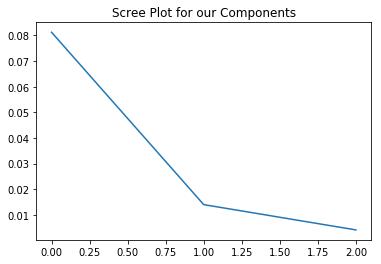

array([0.16563367, 0.16487924, 0.15817033, 0.13674564, 0.19992056])

In [67]:
from sklearn.decomposition import PCA
X = df_movies[['budget', 'revenue', 'popularity',
               'vote_count', 'total_crew', 'budget_sqrt', 
               'revenue_sqrt', 'popularity_sqrt', 'vote_count_sqrt']] 
y = df_movies['vote_average']
y = y.astype('int')

# Scale Data
sklearn_pca = PCA(n_components=3)
pca_feat = X
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(pca_feat)
X_PCA = sklearn_pca.fit_transform(X_normalized)
var_ratios = (list(sklearn_pca.explained_variance_ratio_))
component_variances = (list(sklearn_pca.explained_variance_))
              
# Plotting to decide which features to keep
sorted_eigenvals = sorted(component_variances, reverse=True)
plt.plot(sorted_eigenvals)
plt.title("Scree Plot for our Components")

plt.show()

lr = LinearRegression()

cross_val_score(lr, X_PCA, y, cv=5, scoring='r2')

In [ ]:
plt.show()

print('Percent of variance explained by component \n', var_ratios)
print('\n Eigenvalues: {}'.format(sorted_eigenvals))
chi_selector = SelectKBest(chi2, k=3)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
print(chi_feature)

In [45]:
# using all of the non job features in a vanilla regression
# I think it's weird to scale after adding square roots to try to normalize
# but not positive
X = df_movies[['budget', 'revenue']]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = df_movies['vote_average']

lr = LinearRegression()

# Cross Validation
print('Negative Mean Square Error: {}'.format(
    cross_val_score(lr, X, y, cv=5, scoring='neg_mean_squared_error')))
      
print('R-Squared: {}'.format(
    cross_val_score(lr, X, y, cv=5, scoring='r2'))) 

Negative Mean Square Error: [-1.23350932 -1.3774578  -1.17380291 -1.3537812  -1.14705234]
R-Squared: [0.04851423 0.04602924 0.04959313 0.01653204 0.05979624]


# Try PCA with job vectors

In [60]:
feature_columns = df_parsed.job.unique()

X = job_count[feature_columns]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = job_count['vote_average']
y = y.astype('int')
lr = LinearRegression()

print('Cross Validated R_squared with all jobs:')
print('\n{}'.format(cross_val_score(lr, X, y, cv=5, scoring='r2')))

print('\nCross Validated Neg Mean Squared Error with all jobs:')
print('\n{}'.format(cross_val_score(lr, X, y, cv=5, scoring='neg_mean_squared_error')))

print('Cross Validated R_squared with SCALED jobs:')
print('\n{}'.format(cross_val_score(lr, X_scaled, y, cv=5, scoring='r2')))

print('\nCross Validated Neg Mean Squared Error with SCALED jobs:')
print('\n{}'.format(cross_val_score(lr, X_scaled, y, cv=5, scoring='neg_mean_squared_error')))

Cross Validated R_squared with all jobs:

[-0.09503538 -0.63928064 -0.4899     -0.46658576 -0.21216278]

Cross Validated Neg Mean Squared Error with all jobs:

[-1.43077819 -2.36864167 -1.88783452 -2.06506982 -1.54992295]
Cross Validated R_squared with SCALED jobs:

[-7.09439854e+24 -7.20035688e+09 -4.22915159e+24 -9.78343646e+23
 -6.66836883e+23]

Cross Validated Neg Mean Squared Error with SCALED jobs:

[-9.26957330e+24 -1.04039936e+10 -5.35870753e+24 -1.37758595e+24
 -8.52646034e+23]


In [ ]:
# using all of the non job features in a vanilla regression
# I think it's weird to scale after adding square roots to try to normalize
# but not positive
X = job_count[feature_columns]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = job_count['vote_average']
y = y.astype('int')
lr = LinearRegression()

X = df_movies[['budget', 'revenue', 'popularity', 'vote_count',
              'total_crew']]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = df_movies['vote_average']

lr = LinearRegression()

# Cross Validation
print('Negative Mean Square Error: {}'.format(
    cross_val_score(lr, X, y, cv=5, scoring='neg_mean_squared_error')))
      
print('R-Squared: {}'.format(
    cross_val_score(lr, X, y, cv=5, scoring='r2'))) 

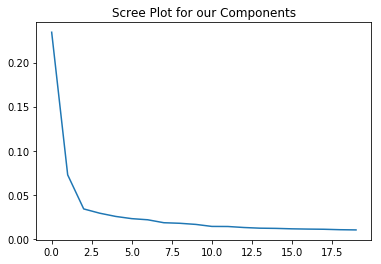

Percent of variance explained by component 
 [0.18066349219854774, 0.05598250306797359, 0.026209249193041854, 0.022468669270781946, 0.019640623778825403, 0.01771364736869863, 0.016715939869999585, 0.014151919278903927, 0.013657085015163165, 0.012672317304877008, 0.010916315719277914, 0.010846254253932383, 0.009965565079122758, 0.009378600941568241, 0.009197304758873481, 0.00881023304663716, 0.008582403770783216, 0.008432411251385469, 0.008041314421559103, 0.007858922810221007]

 Eigenvalues: [0.23436054078596813, 0.07262169868355879, 0.03399919784416114, 0.029146837675729648, 0.025478236660678628, 0.022978521704085174, 0.02168427422721058, 0.018358171952739175, 0.017716262376883854, 0.01643880066991327, 0.014160877907467471, 0.014069992678211574, 0.012927543870425322, 0.012166121454500429, 0.011930940174089438, 0.011428822481695003, 0.011133277478959607, 0.010938703979177627, 0.010431364818274806, 0.010194762524430937]
9 selected features
['Editor', 'Production Design', 'Sound Designer

In [65]:
from sklearn.decomposition import PCA

X = job_count[feature_columns]
y = df_movies['vote_average']
y = y.astype('int')

lr = LinearRegression()

# Scale Data
sklearn_pca = PCA(n_components=20)
pca_feat = X
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(pca_feat)
X_PCA = sklearn_pca.fit_transform(X_normalized)
var_ratios = (list(sklearn_pca.explained_variance_ratio_))
component_variances = (list(sklearn_pca.explained_variance_))
              
# Plotting to decide which features to keep
sorted_eigenvals = sorted(component_variances, reverse=True)
plt.plot(sorted_eigenvals)
plt.title("Scree Plot for our Components")

plt.show()

print('Percent of variance explained by component \n', var_ratios)
print('\n Eigenvalues: {}'.format(sorted_eigenvals))
chi_selector = SelectKBest(chi2, k='all')
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
print(chi_feature)

# Ridge Regression

In [134]:
# Scale Data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

#ridgergr = linear_model.Ridge(alpha=10, fit_intercept=False) 
# Instantiate model for Grid Search
ridge = linear_model.Ridge(alpha, fit_intercept=False)

grid = 

[[0.07692308 0.125      0.         ... 0.         0.         0.        ]
 [0.15384615 0.         0.         ... 0.         0.         0.        ]
 [0.07692308 0.125      0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.07692308 0.125      0.         ... 0.         0.         0.        ]
 [0.07692308 0.125      0.         ... 0.         0.         0.        ]]


In [ ]:
# Define the parameter values that I would like to search
penalty_range = np.arange(100, 200, 10) # 1- 200


model_instance = GradientBoostingClassifier(**params)

param_grid = dict(C=penalty_range)
grid = GridSearchCV(model_instance, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

start_time = time.time()
grid.fit(X,Y)
print(time.time() - start_time)


In [32]:
# examine the first tuple
print(grid.grid_scores_[0].parameters)
print(grid.grid_scores_[0].cv_validation_scores)
print(grid.grid_scores_[0].mean_validation_score)

{'max_depth': 1, 'n_estimators': 100}
[0.75110457 0.74300442 0.7359116 ]
0.7433411071560083


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


# Data Exploration

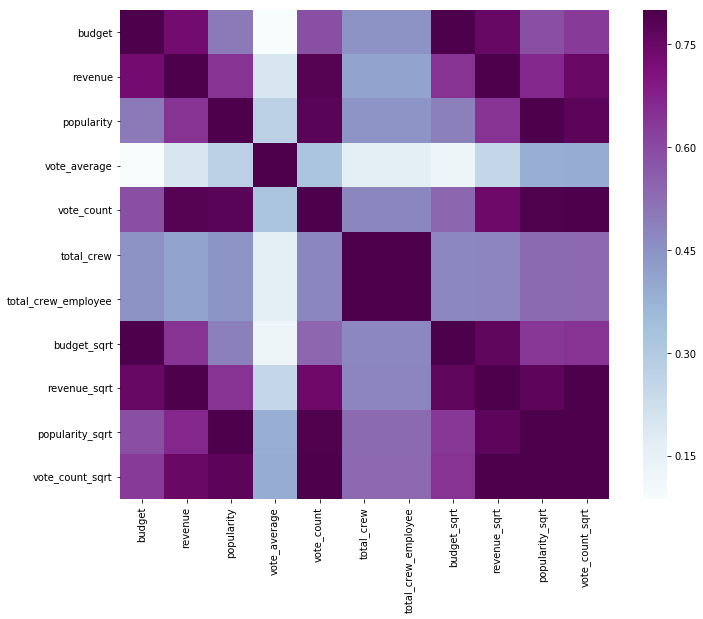

In [72]:
# Make the correlation matrix.
corrmat = df_movies.corr()
#print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True, cmap='BuPu')
plt.show()
# Heatmaps are a great way to get a quick visual read on a big correlation matrix.

# Try to match the correlation numbers to the scatterplots above to get a 
# sense of what each magnitude of correlation can look like.


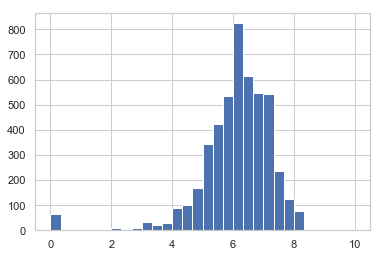

In [96]:
plt.hist(df_movies['vote_average'],bins=30)
plt.show()

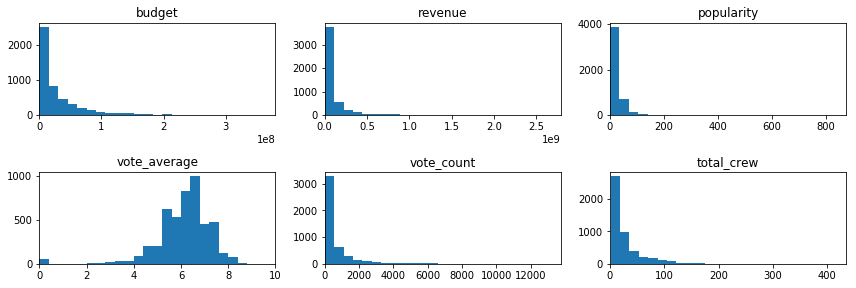

In [9]:
continuous = ['budget', 'revenue', 'popularity', 'vote_average', 'vote_count', 'total_crew']
plt.figure(figsize=(12,8))
n = 0

for x in continuous:    
    n=n+1
    plt.subplot(4,3,n)
    plt.hist(df_movies[x], bins=25)
    plt.xlim(0,df_movies[x].max())
    plt.xlabel('')
    plt.ylabel('')
    
    plt.title(x)
plt.tight_layout()
plt.show()

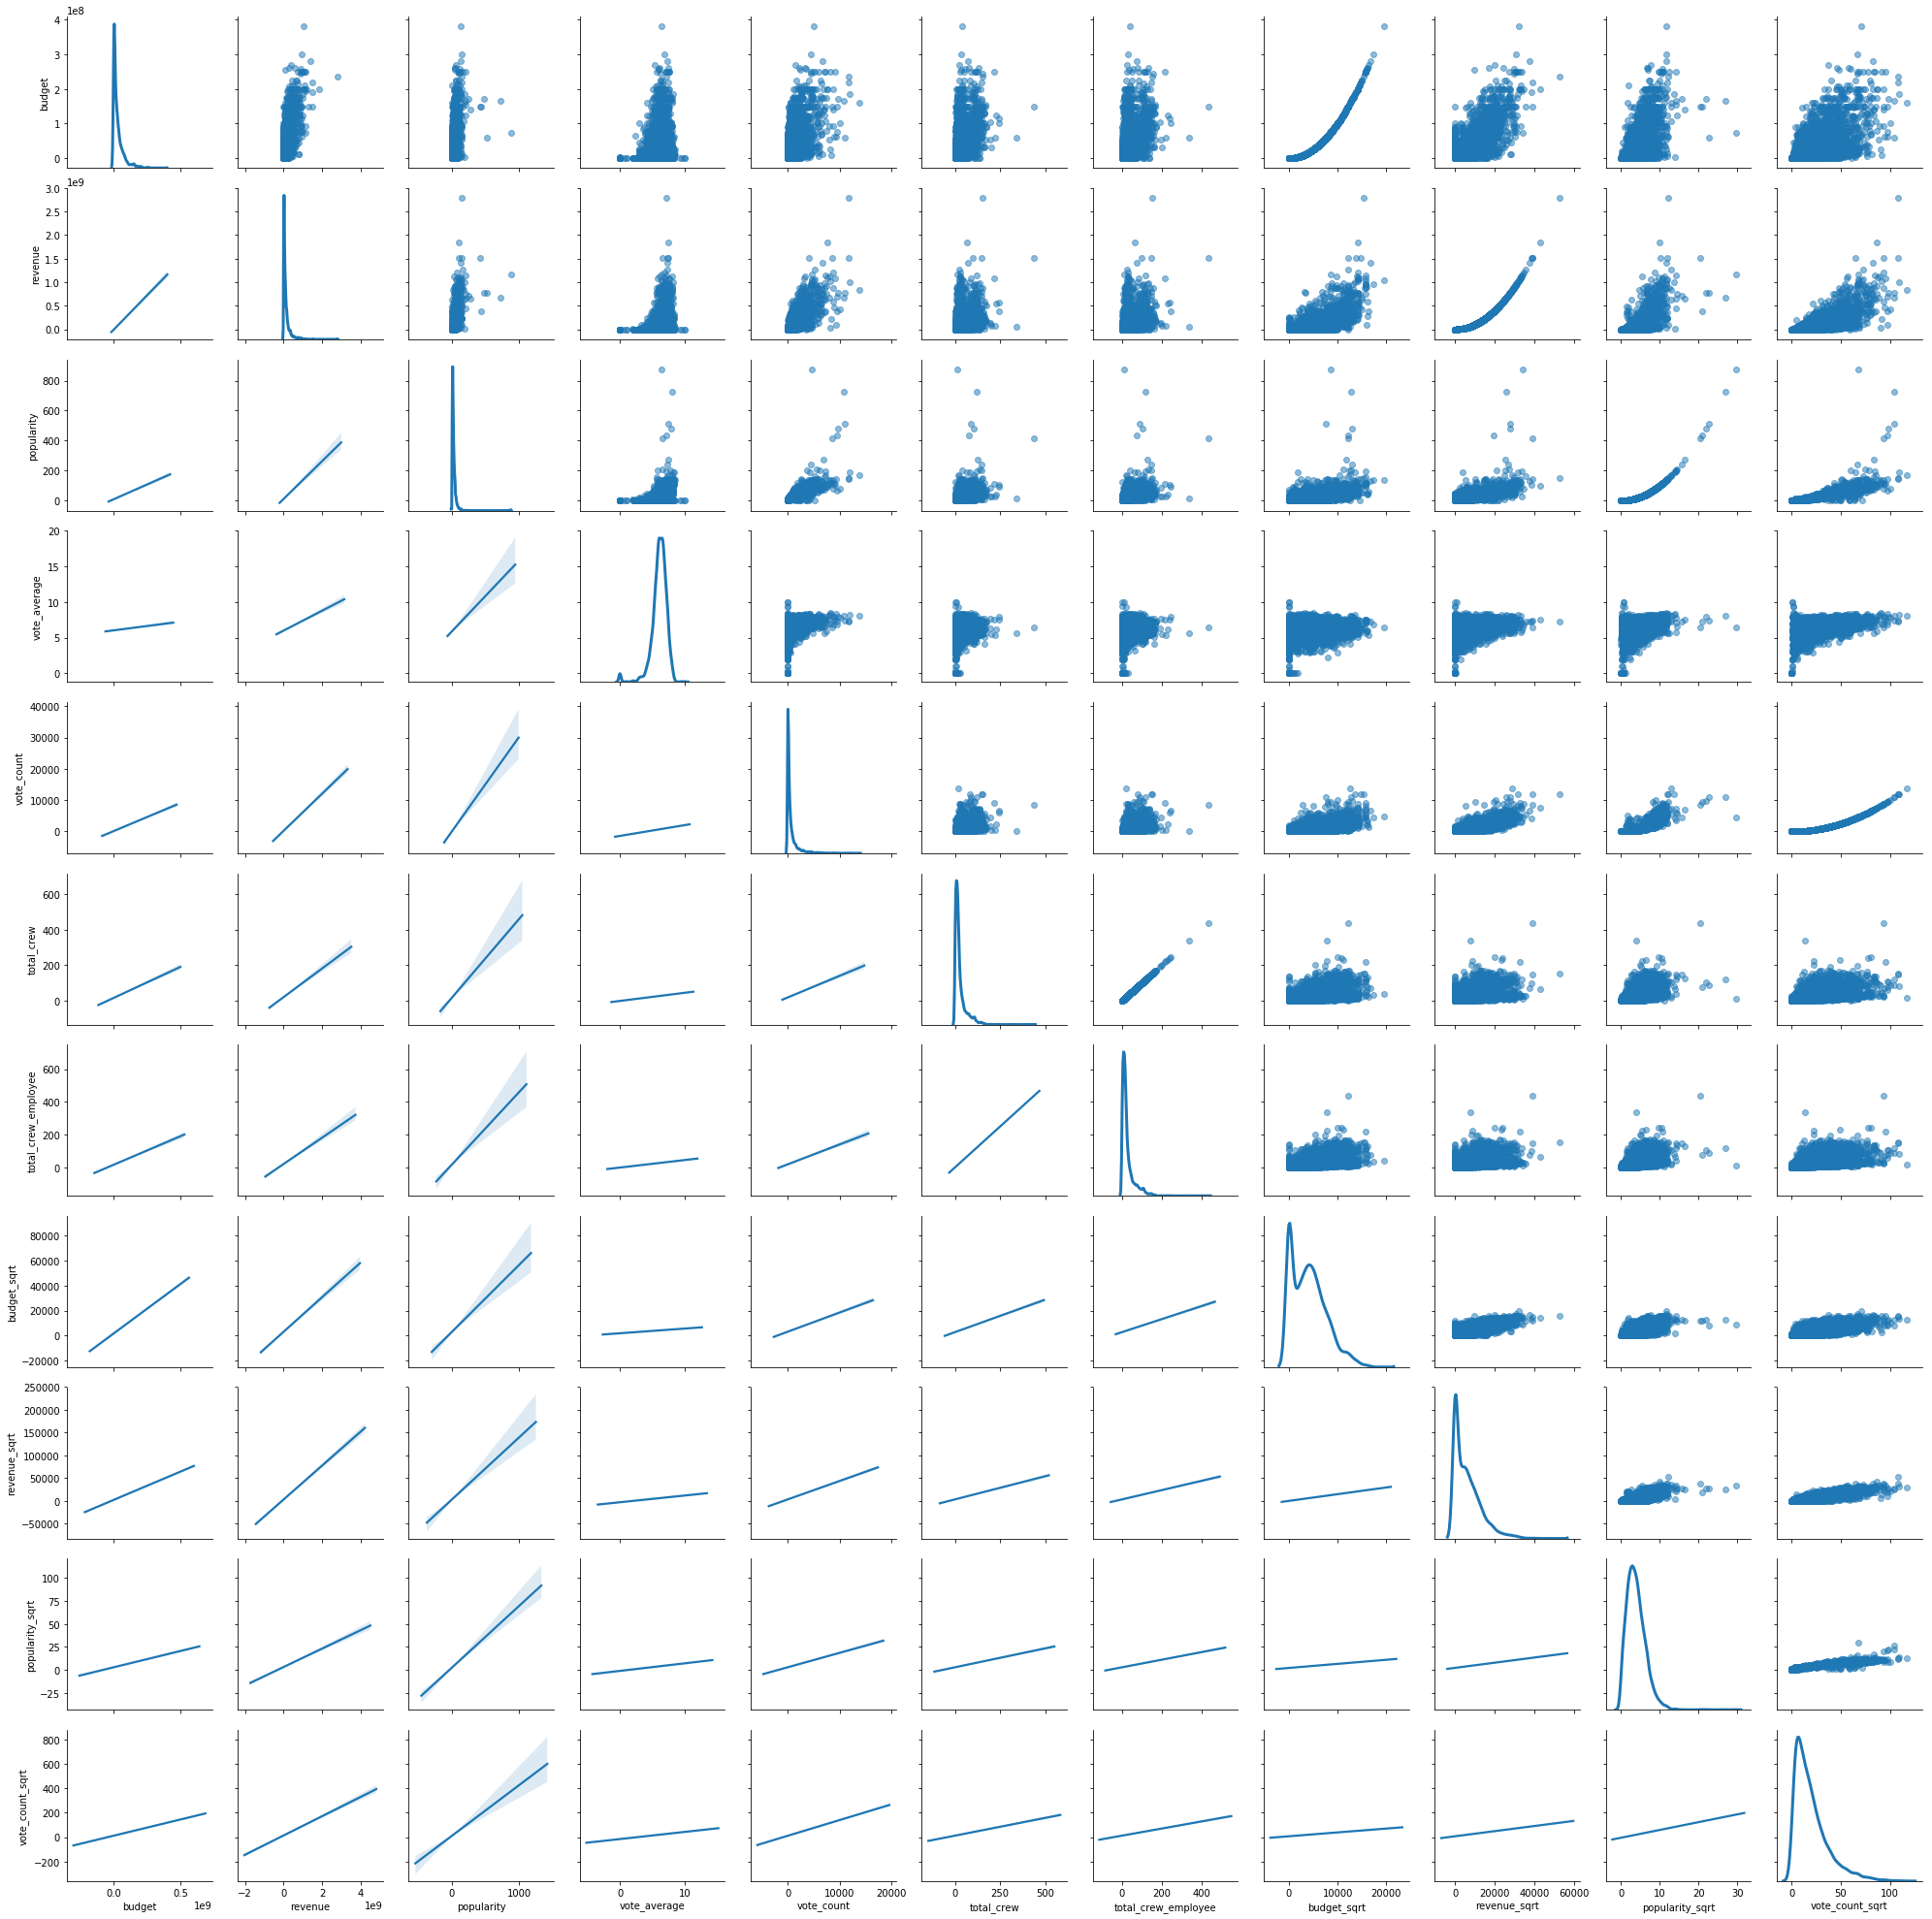

In [73]:
g = sns.PairGrid(df_movies.dropna(), diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot,lw=3)
plt.show()